# Fleshed out example
NOTE: This notebook is pretty rough. It will development  change during development of the code..

#### Imports

In [2]:
# Useful for plottimg
from matplotlib import pyplot as plt

# Useful for calculations
import numpy as np

# Useful for getting lists of files, etc
import os
import glob

# I use *pickle* to load some external "pickled" datasets. Not necessary for anything else. 
import pickle
# Also use xarray to load some external data
import xarray as xr

# I use *mpl.dates* to enter some dates. Not necessary for anything else. 
from matplotlib import dates
from matplotlib.dates import date2num, num2date

# Useful in development..
import importlib

### Find modules and  files we will work with

In [3]:
# Load the modules

# Changing directories because we need to be in the directory below the functions
# (may make this a bit neater later..)
os.chdir('/home/oyvindl/work/code/git_public/sigpyproc/examples/')
os.chdir('../')
from sigpyproc import sig_load, sig_append, sig_calc, sig_draft
from sigpyproc import sig_open_water_correction, sig_vel, sig_toolbox, sig_append
os.chdir('examples/')

In [4]:
# Make a list of the .mat files we want to load 
floc = '/media/oyvindl/ratatosk/data/mooring_data/signature500/m1_1/converted/*'
flist = glob.glob(floc)
for fn in flist:
    if '_avgd' in fn:
        flist.remove(fn)

## Load the data 

##### Load from matfiles to a neatly xarray Dataset 

- Wraps from a simgle time dimension to *(TIME, SAMPLE)*
- Concatenates the many .mat files to a single file
- Various formatting stuff
- Calculate tilt
- Estimates sea ice presence from FOM (and adds "sea ice concentration" fields)

Specifying lat/lon here - that can also be done later

This step takes a while (a minute or so?).

Throws some errors that I haven't investigated (don't seem to matter but I don't want to suppress them, until I'm sure what they are)

In [5]:
importlib.reload(sig_load)

<module 'sigpyproc.sig_load' from '/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_load.py'>

In [21]:
DX = sig_load.matfiles_to_dataset(flist[:2], lat = 79.589, lon = 28.097)

170640 time points, 3555 ensembles. Sample per ensemble: 48


/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_append.py:270: RuntimeWarning: invalid value encountered in sqrt
  180 / np.pi* np.arccos(np.sqrt(
/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_append.py:279: RuntimeWarning: invalid value encountered in sqrt
  180 / np.pi* np.arccos(np.sqrt(


Done. Run sig_funcs.overview() to print some additional details.


##### Have a quick look at the data 

We can look at the file interactively by just typing "DX".

We can also run *sig_load.overview(DX)* for some very basic statistics.

We can also run *sig_toolbox.histogram(DX, [variable name])* to look at the distribution of a variable 

In [ ]:
sig_load.overview(DX)

## Append some external datasets

We can append external data to *DX* using the *sig_append* module. The functions in the module interpolates external data onto the *TIME* grid.

The function *sig_append.add_to_sigdata* is general and can be used to append whatever can be of use.

There are specified functions for appending specific things that are used in subsequent processing: 

- *sig_append.append_atm_pres*: Append **sea level pressure** (used for depth correction)
- *sig_append.append_ctd*: Append **S, T, P from CTD sensor** (used for density and sound speed corrections)
- *sig_append.set_lat, set_lon*: Add (single-value) **lat/lon** (if it wasn't done in the initial loading step)
- *sig_append.append_magdec*: Add **magnetic declination** (used for correction of velocity directions). 

#### Append atmospheric pressure from CARRA atmospheric reanalysis 

Load a dataset containing sea level pressure.

(I have previously collected these data from CARRA reanalysis).

Note that these should be provided in units of **decibars**.

In [ ]:
with open('../testing/development/CARRA_MSL_M1_temp.p', 'rb') as f:
    dmsl = pickle.load(f)

In [ ]:
carra_m1 = xr.open_dataset('/media/oyvindl/ratatosk/data/carra/selected_points/carra_18_22_M1.nc')

In [ ]:
DX_no_msl = DX.copy()

In [ ]:
# Append to the dataset
DX = sig_append.append_atm_pres(DX, carra_m1.msl.data*1e-4, date2num(carra_m1.time))

We now have a *p_atmo* field in *DX*:
Make a quick plot to check that our interpolation worked:

In [ ]:
fig, ax = plt.subplots(figsize = (8, 3))
ax.plot_date(dmsl.time, dmsl.MSL, '-', label = '(Daily) data loaded from .p file')
ax.plot(carra_m1.time, carra_m1.msl*1e-4, '-', label = 'Hourly, from nc file')
ax.plot(DX.TIME, DX.p_atmo, ':', label = 'Data from .nc interpolated to TIME grid')

ax.legend()
ax.set_ylabel('Decibar')
ax.set_xlim(dmsl.time[300], dmsl.time[310])

#### Append CTD data
Next, we add data from a CTD sensor that was mounted rigth below the Signature. We will use it to improve our sound speed and density estimates - it is also interesting to includefor analysis purposes!

In [ ]:
# Load data (which I have prepared in advance)

with open('../testing/development/CARRA_CTD_M1_1_temp.p', 'rb') as f:
    dctd = pickle.load(f)
    
# Chop away nan ends..
ctd_sl = slice(3, -3)
for key in dctd.keys():
    dctd[key] = dctd[key][ctd_sl]

In [ ]:
# Append to the dataset
# (Specifying serial number and description is optional!)
DX = sig_append.append_ctd(DX, dctd.TEMP, dctd.SP, dctd.pres, dctd.time,
             instr_SN = '11111', 
           instr_desc = 'RBR Concerto CTD sensor mounted right below the Signature' )

The *append_ctd* function read T/S/p variables. These were converted to TEOS-10 using the *gsw* module. It also calculated sound speed and density.

We therefore have some new fields in DX, all with the suffix *_CTD*: *SA_CTD, CT_CTD, sound_speed_CTD..*. The descriptions we prescribed, as well as other metadata such as units and full name, should be available in the variable attributes, e.g.:

In [ ]:
DX.SA_CTD

#### Append magnetic declination

In this case, we know that the declination only changes by <0.5 degrees over the deployment. For now, we are happy using a linear interpolation based two values we found for two points in time (from the EMM, extracted using this online calculator: https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm)

In [ ]:
mag_time = [dates.date2num(dates.datetime.date(2018, 9, 1)), 
            dates.date2num(dates.datetime.date(2019, 9, 1))]
magdec = [19.7683447942, 20.1825371364]

In [ ]:
# Append to DX (the attributes are not necessary - 
# but it's a good idea to keep track of this sort 
# of stuff in the file metadata!)

DX = sig_append.append_magdec(DX, magdec, mag_time, 
         attrs = {'note':('Magdec interpolated between extracted from EMM, '
              'extracted using this online calculator: '
              'https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm')})

In [ ]:
# Inspect magdec in DX
DX.magdec

Note that the append_magdec *extrapolates*. Let's look at the actual values: 

In [ ]:
fig, ax = plt.subplots(figsize = (8, 2))
ax.plot(DX.TIME, DX.magdec, label = 'DX.magdec')
ax.plot_date(mag_time, magdec, 'o', label = 'Original points')
ax.legend()
ax.set_ylabel('Degrees')

#### Add AMSR2 SIC

Adding SIC is not necessary for anything. But it is an example of a information that can be useful to include for analysis - remote sensing SIC is also useful for comparing the SIC we have computed from in-situ data! 

In [ ]:
# Load previously extracted data
sic = xr.open_dataset('/home/oyvindl/work/projects/sig500/data/misc/sic/M1M2_AMSR2_SIC.nc')
sic_data = sic.SIC_m1
sic_time = sic.time+0.5 # We add half a day because the daily time stamp is at 00:00

In [ ]:
# 'SIC_AMSR2' specified what we want this variable to be called. A name is mandatory,
# "attrs" specifies attributes/metedata info. Not necessary but useful!
DX = sig_append.add_to_sigdata(DX, sic_data, sic_time, 'SIC_AMSR2', 
               attrs = {'long_name':'AMSR2 UoB sea ice concentration',
        'description':'SIC extracted from the nearest grid point.',
        'sourcefile':'/home/oyvindl/work/projects/sig500/data/misc/sic/M1M2_AMSR2_SIC.nc'})

In [ ]:
# inspect:
DX.SIC_AMSR2

##### Quick look and comparison with "in situ SIC" 
In the *sig_load.matfiles_to_dataset* call in the beginning, we calculated ice presence uring the *FOM* metric, and estimated "SIC" based on this. 

Below we do a quick comparison with the remote sensing SIC that we just added.

Note: We use the function *sig_calc.daily_median* to calculate daily medians

In [ ]:
for nn in list(DX.keys()):
    print(nn)

In [ ]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(DX.TIME, DX.SIC_AMSR2, 'k', zorder = 20, lw = 1, label ='AMSR2 SIC (nearest cell)')
ax.plot(DX.TIME, DX.SIC_FOM, color = 'r', alpha = 0.1)
SIC_FOM_dat, td = sig_calc.daily_average(DX.SIC_FOM, DX.TIME, function = 'mean')
ax.plot(td+0.5, SIC_FOM_dat, color = 'r', alpha = 1, label = 'SIC_FOM (daily)')
SIC_FOM_ALT_dat, td = sig_calc.daily_average(DX.SIC_FOM_ALT, DX.TIME, function = 'mean')
ax.plot_date(td+0.5, SIC_FOM_ALT_dat, '-', color = 'g', alpha = 1, 
             lw = 1, label = 'SIC_FOM_ALT (daily)')
ax.legend()

ax.set_ylabel('Concentration [%]');

-> Looks pretty good!

### Calculate depth
Before we calculate ice drafts and velocities, we want to compute the instrument depth $h$. This is done from a hydrostatic approximation  $$h = \frac{p}{\rho g}$$

Where $p$ is the ocean pressure (*Average_AltimeterPressure*) where we have added back the in-build atmospheric correction, but *subtracted* our the time-varying atmopheric pressure that we added earlier (*p_atmo*).  

$\rho$ is density from CTD (*rho_CTD*) and $g$ is (latitude-dependent) gravitational acceleration calculated using the function *gsw.grav*.

It is possible to calculate depth without atmospheric pressure, in-situ density etc. The function uses everything that is available unless we specify *corr_atmo=False* or *corr_CTD_density=False* in the function call. 

In [377]:
    if 'depth' in DX.keys():
        DEP = DX.depth.mean(dim='SAMPLE')
    else:
        raise Exception('No "depth" field present. -> cannot reject '
        'measurements influenced by sidelobe interference. ' 
        'Run sig_calc.dep_from_p() first.')
    
    if 'SEA_ICE_DRAFT_LE' in DX.keys():
        ICE_DRAFT = DX.SEA_ICE_DRAFT_MEDIAN_LE.copy().fillna(0)
    else:
        ICE_DRAFT = 0
    
    A = DEP - ICE_DRAFT
    cos_theta = np.cos(25*np.pi/180.0)
    s_c = DX.cell_size_oceanvel

    Rmax = A * cos_theta - s_c


In [ ]:
# Doing one calculation withotu the TD densioty correction to see if there is a difference..

DX = sig_calc.dep_from_p(DX, corr_CTD_density=True)

DX0 = DX.copy()
DX0 =sig_calc.dep_from_p(DX0, corr_CTD_density=False)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 3))
ax.plot(DX.TIME, (DX0.depth- DX.depth).mean(dim='SAMPLE')*1e2, )
ax.set_ylabel('[cm]')
ax.set_title('Difference in depth after applying in-situ CTD (vs fixed rho = 1027 kg m-3)')
meandiff = float((DX0.depth-DX.depth).mean())*1e2
ax.plot([float(DX.TIME[0]), float(DX.TIME[-1])], np.ones(2)*meandiff, ':k', label = 'Mean')
ax.legend(); ax.grid()

As we see, the *note* field details which corrections have been applied. 

**A quick sanity check:** we should have $depth\sim~0$ after the instrument was brought on board

In [ ]:
fig, ax = plt.subplots(figsize = (8, 2))
ax.plot(DX.TIME, DX.depth.mean(dim = 'SAMPLE'))#, label = 'DX.magdec')

#ax.plot_date(mag_time, magdec, 'o', label = 'Original points')
ax.set_ylabel('m')
ax.set_xlim(DX.TIME[-20], DX.TIME[-1])
ax.set_ylim(-0.1, 0.1)
ax.grid()
ax.set_title('Instrument "depth" at the end of deployment')

-> Yep, we are about 3 cm off which **seems pretty good.**

### Chopping away on-ship measurements
We actually don't want to include the measurements taken on deck or after/during deployments. We can easily chop everything using the function *sig_load.chop*:

In [ ]:
# Good starting point: Just call the function and follow the prompts. 
DX = sig_load.chop(DX)

We have now chopped away the time on deck durign the recovery, reducing the size of the dataset a bit.

Note that this information is preserved in *DX.history* attribute 

In [ ]:
print(DX.history)

# Draft

We are now ready to calculate the sea ice draft. The basic approach is:

1. Calculate depth of the scattering surface from depth/tilt/sound/speed/altimeter distance.
    - All valid values (open water and ice) are stored as *SURFACE_DEPTH_*
    - Only values during estimated sea ice presence are stored as *SEA_ICE_DRAFT_*
2. Extract a time-varying "open water correction" forcing the long-time moving average open water values to be near zero.
    - Calculate a sound speed correction factor $\beta$ which would make the necessary correction to the open water values.
3. Repeat step 1, but now applying the sound speed $\beta$ to the distance calculation.

##### Step 1: Initial calculation of surface depths


In [354]:
DX = sig_draft.calculate_draft(DX)

/home/oyvindl/anaconda3/envs/oyv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


We have now added a bunch of new fields to *DX* (e.g. *SURFACE_DEPTH_LE*, *SEA_ICE_DRAFT_AST*..).

Note that We do the calculation - separately - for both the *AST* and *LE* altimeter estimates. 

For the *LE* estimate (which typically is better/less noisy, but detects "false keels" near the transducer), we **drop all LE samples where AST and LE disagree by > 0.5 m**. In this case that means dropping a *lot* of samples (something like 1/3 of the dataset), but the hope is that it gives a better estimate.

In [ ]:
DX.SURFACE_DEPTH_AST

##### Step 2: Open water correction
*(Note: this can take a minute or so to run)*

(Describe this here in more detailed later..) 

In [ ]:
# Step 2: Open water correc
DX = sig_open_water_correction.get_Beta_from_OWSD(DX)

### Find sound speed correction Beta

In [ ]:
# Running with the default parameters for now..
DX = sig_open_water_correction.get_Beta_from_OWSD(DX)

*Note*: We have **not** made any adjustments to the draft yet - just estimated $\beta$ (added as the *BETA_open_water_corr_* fields). 

We can examine the correction now to see if we are happy with it using teh *compare_OW_correction* funcion:
(This function is bulky and should be made more practical)

In [ ]:
sig_open_water_correction.compare_OW_correction(DX)

So we can see that we make a larger adjustment  for LE than (eq to ~18 cm) for AST (eq to ~4 cm).

Will look into this a bit later - but for now we will assume that we are happy with out $beta$, and recompute the draft:

### Recompute draft

In [ ]:
DX = sig_draft.calculate_draft(DX)

We have now updated the calculation to include oue $\beta$,m which should improve the estimate and bring open water values nearer to zero.

if we look at the *SEA_ICE_DRAFT_* and *SURFACE_DEPTH_* fields we should see that this is now specified in the metadata (the *note* field).

##### Quick histogram
We can use the *sig_toolbox.histogram* function for a quick look at the results (also shows the attributes including the *note* field)

In [ ]:
sig_toolbox.histogram(DX, 'SEA_ICE_DRAFT_MEDIAN_LE', nbins = 150)

In [ ]:
fig, ax = plt.subplots( figsize = (10, 3))
hkws = {'density':True, 'bins':335, 'range':(-0.5, 6.2), 'alpha':0.5}
ax.hist((DX.SEA_ICE_DRAFT_LE).values.flatten(), **hkws, label = 'LE');
ax.hist((DX.SEA_ICE_DRAFT_AST).values.flatten(), **hkws, label = 'AST');
ax.legend()

In [ ]:
# Compare SD
mean_sd_LE = float(DX.SEA_ICE_DRAFT_LE.std(dim = 'SAMPLE').mean())
mean_sd_AST = float(DX.SEA_ICE_DRAFT_AST.std(dim = 'SAMPLE').mean())
print('Mean SD across samples:')
print('AST: %.2f cm'%(1e2*mean_sd_AST))
print('LE: %.2f cm'%(1e2*mean_sd_LE))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
ax[0].hist((DX.SEA_ICE_DRAFT_LE-DX.SEA_ICE_DRAFT_AST).values.flatten(), 100);
ax[1].hist((DX.SEA_ICE_DRAFT_MEDIAN_LE-DX.SEA_ICE_DRAFT_MEDIAN_AST).values, 100);

**TO DO**

- Continue through with ice velocity. (**X**?)
    - Processing + diagnosis
- Ocean velocity can be prioritised down for now..
- Include chopping functions (**X**?)
- Include save to nc functions
- Make static page for git

## Ice velocity

The ice drift velocity calculation is simpler, consisting of:

- Loading the velocities: *uice, vice* from *AverageIce_VelEast/_VelNorth*
- Applying a quality criterion requiring FOM<10 000 for all 4 beams (equivalent to requiring *ICE_IN_SAMPLE==True*)
    - Rejecting all samples where this does not hold 
- Calculate ensemble median values *Uice, Vice* (default is to use medians, can also use means).
   - Also creating *Uice_SC, Vice_SD* - containing the ensemble standard deviation. 
- Rotate the current vectors to account for magnetic declination.
  - Applied to both *uice* and *Uice*. (Also applying to ocean velocities now..)

##### Create the ice uv fields 

In [ ]:
DX = sig_ice_vel.calculate_drift(DX)

.. we have now added *uice, vice, Uice, Vice, Uice_SD, Vice_SD* to *DX*.

We can compare *uice* with the original *AverageIce_VelEast* field to see what out FOM cleaning has done:

In [ ]:
DX.TIME[9000].data

In [ ]:
ax[1].get_xlim()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (11, 4))
for axn in ax:
    axn.plot(DX.TIME, DX.AverageIce_VelEast.isel(SAMPLE=0), '.', alpha = 0.3,label= 'AverageIce_VelEast (first in each sample) ')
    axn.plot_date(DX.TIME, DX.uice.isel(SAMPLE=0), '-', label= 'uice (first in each sample) ')
    axn.set_ylabel('m/s')
    axn.legend(ncol = 2, fontsize = 8, loc = 4)
ax[1].set_xlim(num2date(DX.TIME[12000]), num2date(DX.TIME[13000]))
ax[1].text(0.1, 0.8, 'ZOOMED', fontsize = 20, fontweight = 'bold', transform=ax[1].transAxes)

##### Inspect
The function *sig_toolbox.plot_ellipse_icevel* is useful to get a quick look at the ice velocity data. It shows the u/v spread, mean and low-passed velocity, and the variance ellipse (of the low-passed currents)

In [ ]:
sig_toolbox.plot_ellipse_icevel(DX);

### Rotating for magnetic declination

Earlier, we added the *magdec* field to *DX*. We can now use it to rotate the ice velocity vectors:

In [ ]:
DX = sig_ice_vel.rotate_vels_magdec(DX)

The declination is about 20 degrees, so we should expect a CW rotation of the **u** vectors by about 20 degrees. Check this by using *plot_ellipse_icevel* again: 

In [ ]:
sig_toolbox.plot_ellipse_icevel(DX);

--> OK. 

Note that some metadata has been added to the velocity fields, e.g.:

In [ ]:
DX.Uice.attrs

## Ocean velocities (TBW)

In [885]:
importlib.reload(sig_load)
importlib.reload(sig_vel)

<module 'sigpyproc.sig_vel' from '/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_vel.py'>

In [ ]:
DX = sig_load.matfiles_to_dataset(flist, lat = 79.589, lon = 28.097)
DX = sig_calc.dep_from_p(DX)
DX = sig_vel._calculate_bin_depths(DX)
DX = sig_vel.calculate_ocean_vel(DX)

/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_append.py:270: RuntimeWarning: invalid value encountered in sqrt
  180 / np.pi* np.arccos(np.sqrt(
/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_append.py:279: RuntimeWarning: invalid value encountered in sqrt
  180 / np.pi* np.arccos(np.sqrt(


In [ ]:
fig, ax = plt.subplots()
ax.scatter(DX.Uocean.isel(BINS=4), DX.Vocean.isel(BINS=4), color = 'k', alpha = 0.07, s = 0.1)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.plot([0, DX.Uocean.mean().data], [0, DX.Vocean.mean().data], '-r')

In [ ]:
fig, ax = plt.subplots(2, 1, )
ax[0].pcolormesh(DX.Uocean, vmin = -0.3, vmax =0.3, cmap = 'RdBu')
ax[1].pcolormesh(DX.Vocean, vmin = -0.3, vmax =0.3, cmap = 'RdBu')

In [ ]:
DX = sig_vel.reject_sidelobe(DX)

In [ ]:
DX = sig_vel.clear_empty_bins(DX)

In [ ]:
DX = sig_vel.uvoc_mask_range(DX)

In [ ]:
DX = sig_vel.clear_empty_bins(DX)

In [ ]:
fig, ax = plt.subplots(2, 1, )
ax[0].pcolormesh(DX.Uocean, vmin = -0.2, vmax =0.2, cmap = 'RdBu')
ax[1].pcolormesh(DX.Vocean, vmin = -0.2, vmax =0.2, cmap = 'RdBu')

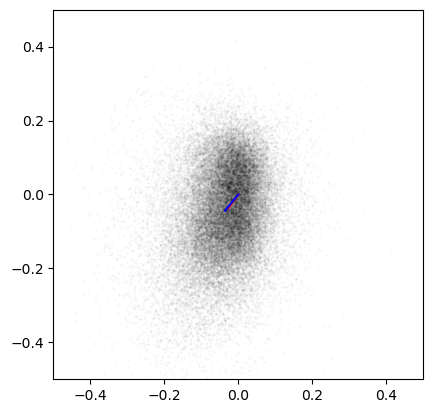

In [639]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(DX.Uocean.isel(BINS=4), DX.Vocean.isel(BINS=4), color = 'k', alpha = 0.07, s = 0.1)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.plot([0, DX.Uocean.isel(BINS=4).median().data], [0, DX.Vocean.isel(BINS=4).median().data], '-r')
ax.plot([0, DX.Uocean.isel(BINS=4).mean().data], [0, DX.Vocean.isel(BINS=4).mean().data], '-b')

In [638]:
DX = sig_append.append_magdec(DX, 20)

In [640]:
DX = sig_vel.rotate_vels_magdec(DX)

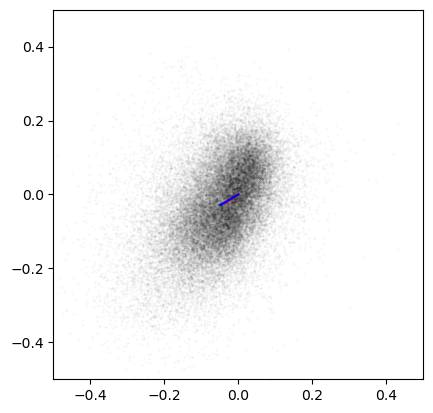

In [641]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(DX.Uocean.isel(BINS=4), DX.Vocean.isel(BINS=4), color = 'k', alpha = 0.07, s = 0.1)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.plot([0, DX.Uocean.isel(BINS=4).median().data], [0, DX.Vocean.isel(BINS=4).median().data], '-r')
ax.plot([0, DX.Uocean.isel(BINS=4).mean().data], [0, DX.Vocean.isel(BINS=4).mean().data], '-b')

In [642]:
print(DX.Uocean.processing_history)

Loaded from Average_VelEast/Average_VelEast fields.

Rejected samples close enough to the surface to be affected by sidelobe interference (rejecting 52.88% of velocity samples).
THRESHOLD_BASED DATA CLEANING : 
Start: 14104608 initial valid samples.
Dropping (NaNing samples where):
- # Speed < 1.50 ms-1 # -> Dropped 60774 pts (0.43%)
- # Tilt < 5.00 deg # -> Dropped 8418 pts (0.06%)
- # Sound sp in [1400, 1560] ms-1 # -> Dropped 0 pts (0.00%)
- # Corr (all beams) < 60.0 % # -> Dropped 33907 pts (0.24%)
- # Amp (all beams) in [30, 85] db # -> Dropped 19226 pts (0.14%)
- # Above amp bumps > 20 db # -> Dropped 500137 pts (3.58%)
End: 13482146 valid samples.
Rotated CW by an average of 20.00 degrees to correct for magnetic declination. 



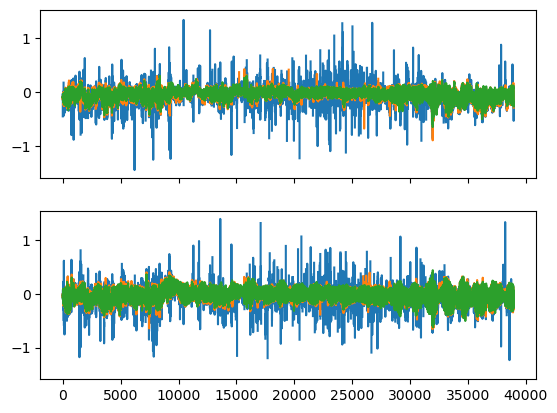

In [643]:
fig, ax = plt.subplots(2, 1, sharex = True, sharey = True)
ax[0].plot(DX.Uocean.isel(BINS=-1))
ax[0].plot(DX.Uocean.isel(BINS=4))

ax[0].plot(DX.Uocean.isel(BINS=0))
ax[1].plot(DX.Vocean.isel(BINS=-1))
ax[1].plot(DX.Vocean.isel(BINS=4))

ax[1].plot(DX.Vocean.isel(BINS=0))

#### Interpolating velocity

In [815]:
DX = sig_vel.interp_oceanvel(DX, 10)

KeyboardInterrupt: 

Text(0, 0.5, 'm/s')

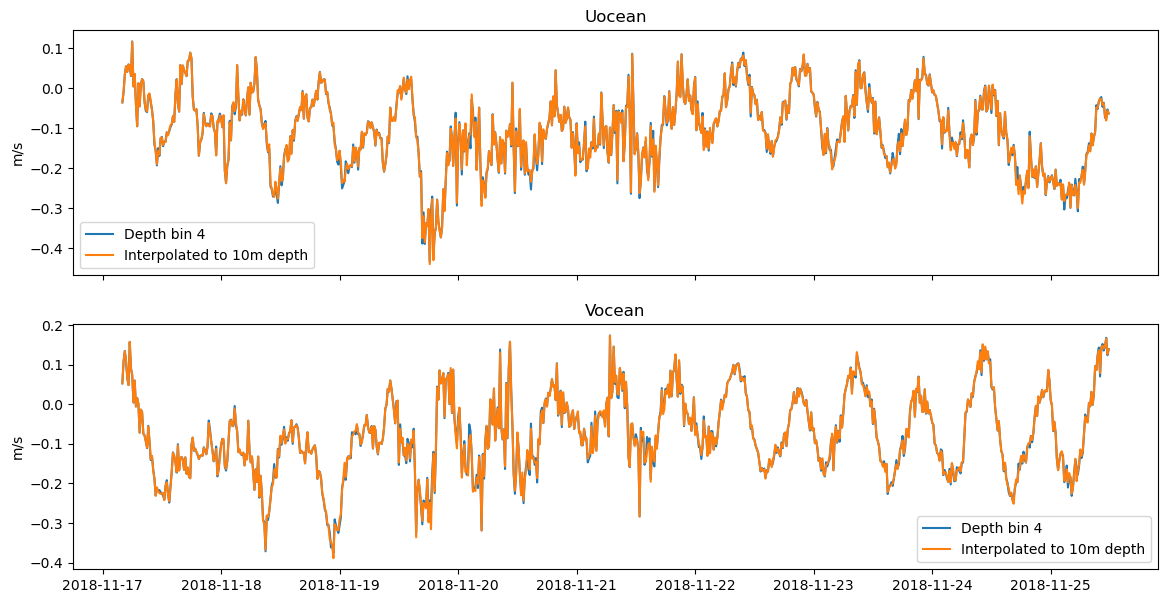

In [732]:

bin_nr = 4
fig, ax = plt.subplots(2, 1, sharex = True, figsize = (14, 7))
time_slice = slice(4000, 4800)
subset_time = DX.TIME.isel(TIME = time_slice)

ax[0].plot(subset_time, DX.Uocean.isel(BINS=bin_nr, TIME = time_slice), label = 'Depth bin %i'%bin_nr)
ax[0].plot(subset_time, DX.Uocean_10m.isel(TIME = time_slice), label = 'Interpolated to 10m depth')
ax[0].legend()

ax[1].plot(subset_time, DX.Vocean.isel(BINS=bin_nr, TIME = time_slice), label = 'Depth bin %i'%bin_nr)
ax[1].plot_date(subset_time, DX.Vocean_10m.isel(TIME = time_slice), '-', label = 'Interpolated to 10m depth')
ax[1].legend()
ax[0].set_title('Uocean')
ax[1].set_title('Vocean')
ax[0].set_ylabel('m/s')
ax[1].set_ylabel('m/s')

#ax[0].set_xlim(4000, 4800)

In [837]:
importlib.reload(sig_vel)

<module 'sigpyproc.sig_vel' from '/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_vel.py'>

In [838]:
DX = sig_vel._calculate_uvocean_avg(DX.copy())
print(DX.Uocean.std().data)
print(DX.Uocean.attrs['processing_history'][-67:])

0.09947322570540208
 an average of 20.00 degrees to correct for magnetic declination. 



In [847]:
DX1 = sig_vel._calculate_uvocean_avg(DX.copy(), min_good_pct=80).copy()
print(DX1.Uocean.std().data)
print(DX1.Uocean.attrs['processing_history'][-67:])

0.09453808424250514
ejected 13629 of 289759 ensembles (4.70%) with <80.0% good samples.


In [883]:
DX2 = sig_vel._calculate_uvocean_avg(DX.copy(), min_good_pct=99).copy()
print(DX2.Uocean.std().data)
print(DX2.Uocean.attrs['processing_history'][-67:])

0.09294449739361828
jected 48013 of 289759 ensembles (16.57%) with <99.0% good samples.


In [884]:
print(np.sum(np.isnan(DX2.Uocean)).data)
print(np.sum(np.isnan(DX1.Uocean)).data)
print(np.sum(np.isnan(DX.Uocean)).data)

70086
35702
70086


Text(0, 0.5, 'm/s')

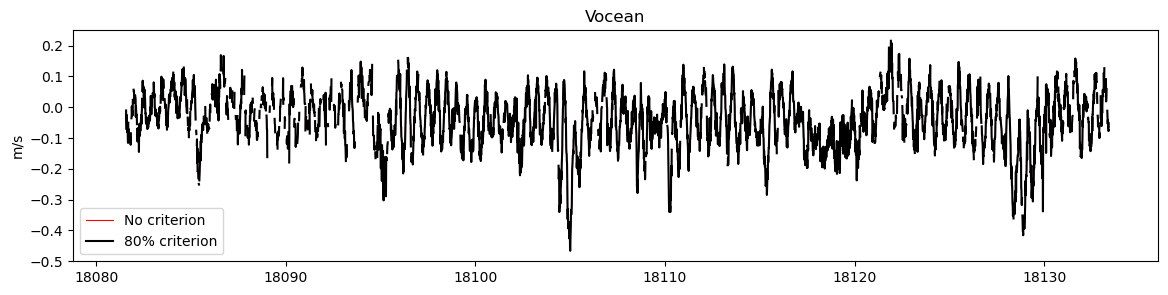

In [880]:

bin_nr = 6
fig, ax = plt.subplots(
    figsize = (14, 3))
add = 22000
time_slice = slice(4000+add, 9000+add)
subset_time = DX.TIME.isel(TIME = time_slice)

ax.plot(subset_time, DX.Uocean.isel(BINS=bin_nr, TIME = time_slice), 'r', lw = 0.8,label = 'No criterion')
#ax.plot(subset_time, DX2.Uocean.isel(BINS=bin_nr, TIME = time_slice), 'b', label = '40% criterion')
ax.plot(subset_time, DX1.Uocean.isel(BINS=bin_nr, TIME = time_slice), 'k', label = '80% criterion')

ax.legend()


ax.set_title('Vocean')
ax.set_ylabel('m/s')


## Exporting

In [ ]:
sig_load.overview(DX)

In [ ]:
DX

In [ ]:
sig_load.to_nc(DX, 'testfile.nc', export_vars= ['SIC_FOM'], icedraft = True, icevel = True, oceanvel = False)

#### Read the testfile..

In [ ]:
TF = xr.open_dataset('testfile.nc')

In [ ]:
TF.attrs.conf

In [ ]:
TF.close()